In [19]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [20]:
# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

# Load IMDB dataset
DATA_DIR = './tensorflow-datasets/'
train_ds = tfds.load('imdb_reviews', split='train[:90%]', data_dir=DATA_DIR, shuffle_files=True)
val_ds = tfds.load('imdb_reviews', split='train[-10%:]', data_dir=DATA_DIR, shuffle_files=True)
test_ds = tfds.load('imdb_reviews', split='test', data_dir=DATA_DIR, shuffle_files=True)

# Parameters - REDUCED MAX_LENGTH for faster training
VOCAB_SIZE = 10000
MAX_LENGTH = 128  # Reduced from 200 - most reviews are shorter anyway
BATCH_SIZE = 64   # Increased from 32 for faster training

# Create vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_LENGTH
)

# Adapt on training data
vectorize_layer.adapt(train_ds.map(lambda x: x['text']))

def preprocess(data):
    text = vectorize_layer(data['text'])
    label = data['label']
    return text, label

# Preprocess datasets
train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Data loaded and preprocessed!")
print(f"Max length: {MAX_LENGTH}, Batch size: {BATCH_SIZE}")

2025-11-10 16:48:01.099848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Data loaded and preprocessed!
Max length: 128, Batch size: 64


In [21]:
# ============================================================================
# ARCHITECTURE 1: LSTM WITH ADDITIVE ATTENTION
# ============================================================================

def create_lstm_model(embedding_dim=128, lstm_units=64, l2_reg=0.01, learning_rate=0.001):
    """
    LSTM model with AdditiveAttention and L2 regularization
    """
    inputs = tf.keras.Input(shape=(MAX_LENGTH,))
    
    # Embedding
    x = tf.keras.layers.Embedding(
        VOCAB_SIZE, 
        embedding_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(inputs)
    
    # LSTM layer - return sequences for attention
    lstm_out = tf.keras.layers.LSTM(
        lstm_units, 
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(x)
    
    # Additive Attention
    query = lstm_out[:, -1:, :]  # Last timestep as query
    attention = tf.keras.layers.AdditiveAttention()([query, lstm_out])
    attention = tf.keras.layers.Flatten()(attention)
    
    # Output layer
    outputs = tf.keras.layers.Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)
    )(attention)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("LSTM with AdditiveAttention defined!")

LSTM with AdditiveAttention defined!


In [22]:
# ============================================================================
# ARCHITECTURE 2: TRANSFORMER
# ============================================================================

class TransformerBlock(tf.keras.layers.Layer):
    """Simple Transformer block - optimized for speed"""
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim // num_heads  # More efficient key_dim
        )
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization()
        self.layernorm2 = tf.keras.layers.LayerNormalization()
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def create_transformer_model(embedding_dim=128, num_heads=4, ff_dim=128, dropout_rate=0.3, learning_rate=0.001):
    """
    Transformer model with Dropout regularization
    """
    inputs = tf.keras.Input(shape=(MAX_LENGTH,))
    
    # Embedding
    x = tf.keras.layers.Embedding(VOCAB_SIZE, embedding_dim)(inputs)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Transformer block
    x = TransformerBlock(embedding_dim, num_heads, ff_dim, dropout_rate)(x)
    
    # Global pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

print("Transformer model defined!")

Transformer model defined!


In [23]:
# ============================================================================
# TRAINING CONFIGURATION
# ============================================================================

def train_model(model, name, epochs=15):  # Reduced from 20
    """Train model with early stopping"""
    print(f"\nTraining: {name}")
    print("="*60)
    
    # Early stopping with patience=5
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )
    
    print(f"\nBest val accuracy: {max(history.history['val_accuracy']):.4f}")
    return history

print("Training function defined!")

Training function defined!


In [30]:
# ============================================================================
# EXPERIMENT 1: LSTM - CONFIGURATION 1
# ============================================================================

print("\n" + "="*60)
print("LSTM WITH ADDITIVE ATTENTION - CONFIG 1")
print("="*60)

lstm_model_1 = create_lstm_model(
    embedding_dim=128,
    lstm_units=64,
    l2_reg=0.0001,
    learning_rate=0.001
)

history_lstm_1 = train_model(lstm_model_1, "LSTM Config 1")


LSTM WITH ADDITIVE ATTENTION - CONFIG 1

Training: LSTM Config 1
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 33s 75ms/step - accuracy: 0.7824 - loss: 0.5006 - val_accuracy: 0.8336 - val_loss: 0.4287
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.8641 - loss: 0.3833 - val_accuracy: 0.8368 - val_loss: 0.4361
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.8855 - loss: 0.3583 - val_accuracy: 0.8348 - val_loss: 0.4481
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.8984 - loss: 0.3392 - val_accuracy: 0.8288 - val_loss: 0.5204
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.9103 - loss: 0.3256 - val_accuracy: 0.8320 - val_loss: 0.5106
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 72ms/step - accuracy: 0.9164 - loss: 0.3139 - val_accuracy: 0.8276 - val_loss: 0.5713

Best val accuracy: 0.8368


In [25]:
# ============================================================================
# EXPERIMENT 2: LSTM - CONFIGURATION 2
# ============================================================================

print("\n" + "="*60)
print("LSTM WITH ADDITIVE ATTENTION - CONFIG 2")
print("="*60)

lstm_model_2 = create_lstm_model(
    embedding_dim=256,
    lstm_units=128,
    l2_reg=0.001,
    learning_rate=0.0005
)

history_lstm_2 = train_model(lstm_model_2, "LSTM Config 2")


LSTM WITH ADDITIVE ATTENTION - CONFIG 2

Training: LSTM Config 2
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 62s 171ms/step - accuracy: 0.7279 - loss: 0.8303 - val_accuracy: 0.8016 - val_loss: 0.5301
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step - accuracy: 0.8264 - loss: 0.4991 - val_accuracy: 0.8136 - val_loss: 0.5236
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.8414 - loss: 0.4723 - val_accuracy: 0.8232 - val_loss: 0.5330
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step - accuracy: 0.8526 - loss: 0.4508 - val_accuracy: 0.8196 - val_loss: 0.5627
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.8644 - loss: 0.4349 - val_accuracy: 0.8280 - val_loss: 0.4873
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.8732 - loss: 0.4203 - val_accuracy: 0.8312 - val_loss: 0.4915
Epoch 7/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 55s 155ms/step - accuracy: 0.8809 - loss: 0.4067 - val_accuracy: 0.8204 - val_loss: 0.5216
Epoch 8/15
352/35

In [26]:
# ============================================================================
# EXPERIMENT 3: TRANSFORMER - CONFIGURATION 1
# ============================================================================

print("\n" + "="*60)
print("TRANSFORMER - CONFIG 1")
print("="*60)

transformer_model_1 = create_transformer_model(
    embedding_dim=128,
    num_heads=4,
    ff_dim=128,
    dropout_rate=0.3,
    learning_rate=0.001
)

history_transformer_1 = train_model(transformer_model_1, "Transformer Config 1")


TRANSFORMER - CONFIG 1

Training: Transformer Config 1
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 69s 186ms/step - accuracy: 0.7840 - loss: 0.4454 - val_accuracy: 0.8376 - val_loss: 0.3510
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.8820 - loss: 0.2863 - val_accuracy: 0.8460 - val_loss: 0.3935
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 65s 183ms/step - accuracy: 0.9094 - loss: 0.2291 - val_accuracy: 0.8424 - val_loss: 0.4422
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 63s 180ms/step - accuracy: 0.9266 - loss: 0.1901 - val_accuracy: 0.8236 - val_loss: 0.6089
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 64s 181ms/step - accuracy: 0.9464 - loss: 0.1492 - val_accuracy: 0.8164 - val_loss: 0.7770
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 64s 181ms/step - accuracy: 0.9613 - loss: 0.1112 - val_accuracy: 0.8116 - val_loss: 0.8952

Best val accuracy: 0.8460


In [27]:
# ============================================================================
# EXPERIMENT 4: TRANSFORMER - CONFIGURATION 2
# ============================================================================

print("\n" + "="*60)
print("TRANSFORMER - CONFIG 2")
print("="*60)

# Reduced model size for Config 2 to speed up training
transformer_model_2 = create_transformer_model(
    embedding_dim=128,  # Reduced from 256
    num_heads=4,        # Reduced from 8
    ff_dim=256,         # Kept same
    dropout_rate=0.2,
    learning_rate=0.0005
)

history_transformer_2 = train_model(transformer_model_2, "Transformer Config 2")


TRANSFORMER - CONFIG 2

Training: Transformer Config 2
Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 74s 201ms/step - accuracy: 0.7729 - loss: 0.4578 - val_accuracy: 0.8512 - val_loss: 0.3410
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.8788 - loss: 0.2902 - val_accuracy: 0.8456 - val_loss: 0.3591
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.8994 - loss: 0.2442 - val_accuracy: 0.8400 - val_loss: 0.3972
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 70s 200ms/step - accuracy: 0.9170 - loss: 0.2059 - val_accuracy: 0.8384 - val_loss: 0.4343
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 71s 200ms/step - accuracy: 0.9343 - loss: 0.1729 - val_accuracy: 0.8312 - val_loss: 0.4890
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 74s 209ms/step - accuracy: 0.9458 - loss: 0.1445 - val_accuracy: 0.8244 - val_loss: 0.5732

Best val accuracy: 0.8512


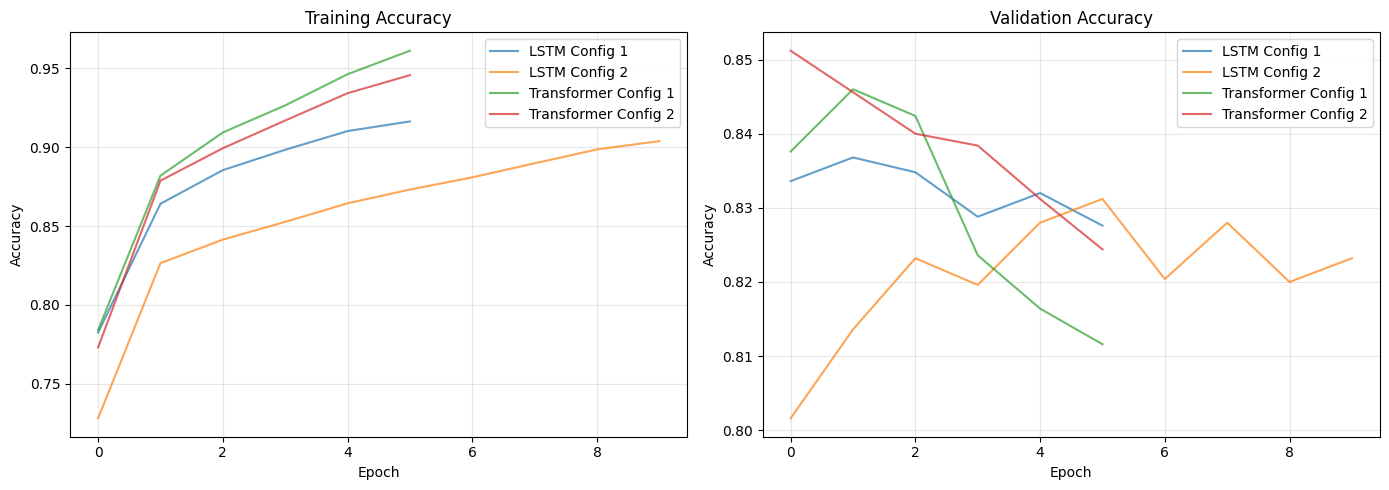

Training curves saved!


In [31]:
# ============================================================================
# VISUALIZATION
# ============================================================================

# Collect all histories and names
histories = [history_lstm_1, history_lstm_2, history_transformer_1, history_transformer_2]
names = ['LSTM Config 1', 'LSTM Config 2', 'Transformer Config 1', 'Transformer Config 2']

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for history, name in zip(histories, names):
    axes[0].plot(history.history['accuracy'], label=name, alpha=0.7)
    axes[1].plot(history.history['val_accuracy'], label=name, alpha=0.7)

axes[0].set_title('Training Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training curves saved!")


TEST SET EVALUATION
LSTM Config 1             - Accuracy: 0.8192, Loss: 0.4579
LSTM Config 2             - Accuracy: 0.8078, Loss: 0.5179
Transformer Config 1      - Accuracy: 0.8253, Loss: 0.3953
Transformer Config 2      - Accuracy: 0.8316, Loss: 0.3787


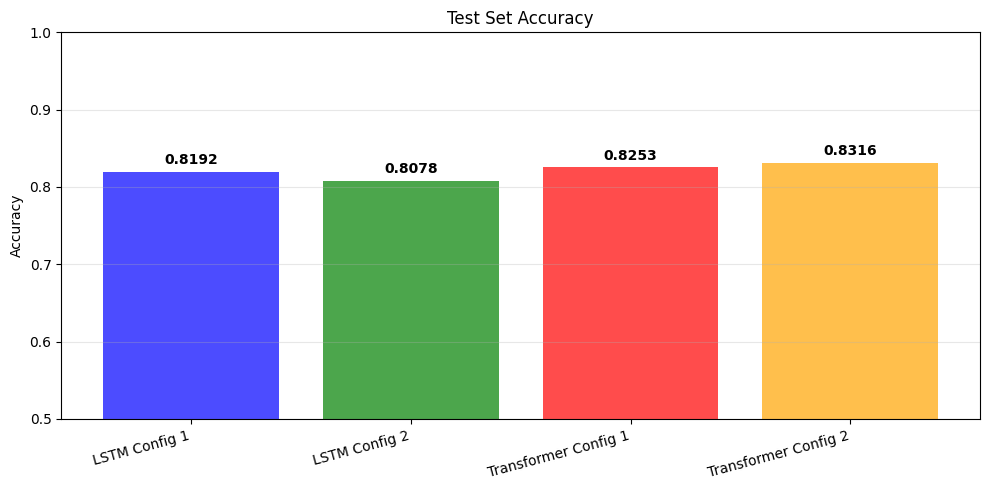


Evaluation complete!


In [32]:
# ============================================================================
# EVALUATION ON TEST SET
# ============================================================================

models = [lstm_model_1, lstm_model_2, transformer_model_1, transformer_model_2]

print("\n" + "="*60)
print("TEST SET EVALUATION")
print("="*60)

results = []
for model, name in zip(models, names):
    loss, acc = model.evaluate(test_ds, verbose=0)
    results.append({'name': name, 'loss': loss, 'accuracy': acc})
    print(f"{name:25s} - Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# Plot test results
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
accuracies = [r['accuracy'] for r in results]
ax.bar(range(len(results)), accuracies, color=['blue', 'green', 'red', 'orange'], alpha=0.7)
ax.set_xticks(range(len(results)))
ax.set_xticklabels(names, rotation=15, ha='right')
ax.set_ylabel('Accuracy')
ax.set_title('Test Set Accuracy')
ax.set_ylim([0.5, 1.0])
ax.grid(True, alpha=0.3, axis='y')

for i, v in enumerate(accuracies):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('test_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nEvaluation complete!")